In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.dates as mdates
# from datetime import datetime
import netCDF4 as nc
import scipy 
from xmhw.xmhw import threshold, detect
import datetime
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as ticker

#### deal with different formats of eventDate

In [3]:
df = pd.read_csv("ER_OBIS.csv", low_memory=False) 
df['eventDate'] = pd.to_datetime(df['eventDate'], format='mixed', dayfirst=True, errors='coerce')

df = df[['decimalLatitude', 'decimalLongitude','eventDate','occurrenceStatus','organismQuantity','organismQuantityType','date_year','sst','sss']]
df

,decimalLatitude,decimalLongitude,eventDate,occurrenceStatus,organismQuantity,organismQuantityType,date_year,sst,sss
0,-43.284500,147.167389,2009-04-01 00:00:00,present,NaN,Biomass kg wet per sq m,2009.0,13.88,35.24
1,-42.056900,148.313900,2021-04-19 00:00:00,present,dense,cover,2021.0,14.82,35.35
2,-43.138400,147.968100,2011-01-24 00:00:00,present,40,percent,2011.0,14.30,35.27
3,-35.519218,138.174164,2007-02-21 00:00:00,present,NaN,Biomass kg wet per sq m,2007.0,16.97,35.93
4,-43.166000,147.982400,2001-10-25 13:00:00+00:00,present,40-80%,Canopy cover (%),2001.0,14.30,35.27
...,...,...,...,...,...,...,...,...,...
93399,-43.146100,148.000000,2021-04-22 00:00:00,present,middle,cover,2021.0,14.37,35.27
93400,-38.672000,145.665000,2000-01-11 00:00:00,present,NaN,NaN,2000.0,15.73,35.71
93401,-42.853200,147.976200,2021-04-23 00:00:00,present,middle,cover,2021.0,14.31,35.27
93402,-41.868641,148.303436,1993-05-20 00:00:00,present,NaN,Biomass kg wet per sq m,1993.0,14.94,35.37


### summarise coordinates into 1/4 degree

In [7]:
group_df = df.groupby('date_year', group_keys=True)
# group_df.get_group(1983)

In [8]:
def round_coordinates(coord):
    return np.round(coord * 4) / 4  # Rounding to 0.25 degrees


In [9]:
# Apply the rounding function to latitude and longitude columns
rounded_df = group_df.apply(lambda x: x.assign(Latitude=x['decimalLatitude'].apply(round_coordinates),
                                                    Longitude=x['decimalLongitude'].apply(round_coordinates)))
# Reset index on the resulting DataFrame
rounded_df.reset_index(inplace=True, drop=True)
rounded_df

,decimalLatitude,decimalLongitude,eventDate,occurrenceStatus,organismQuantity,organismQuantityType,date_year,sst,sss,Latitude,Longitude
0,-33.603298,26.901899,1893-06-10 12:00:00+00:00,NaN,NaN,NaN,1893.0,20.22,35.39,-33.50,27.00
1,-33.603298,26.901899,1894-10-10 12:00:00+00:00,NaN,NaN,NaN,1894.0,20.22,35.39,-33.50,27.00
2,-33.603298,26.901899,1895-01-01 12:00:00+00:00,NaN,NaN,NaN,1895.0,20.22,35.39,-33.50,27.00
3,-33.603298,26.901899,1895-01-01 12:00:00+00:00,NaN,NaN,NaN,1895.0,20.22,35.39,-33.50,27.00
4,-33.603298,26.901899,1895-11-26 12:00:00+00:00,NaN,NaN,NaN,1895.0,20.22,35.39,-33.50,27.00
...,...,...,...,...,...,...,...,...,...,...,...
93365,-42.319200,148.325200,2021-04-20 00:00:00,present,sparse,cover,2021.0,14.76,35.31,-42.25,148.25
93366,-42.860200,147.972300,2021-04-23 00:00:00,present,middle,cover,2021.0,14.31,35.27,-42.75,148.00
93367,-43.151100,147.995500,2021-04-22 00:00:00,present,middle,cover,2021.0,14.30,35.27,-43.25,148.00
93368,-43.146100,148.000000,2021-04-22 00:00:00,present,middle,cover,2021.0,14.37,35.27,-43.25,148.00


In [10]:
# Group the data by rounded latitude and longitude and count occurrences
summarized_df = rounded_df.groupby(['date_year', 'Latitude', 'Longitude']).size().reset_index(name='Occurrences')  #
summarized_df = summarized_df[(summarized_df.date_year > 1980)&(summarized_df.date_year < 2023) & (summarized_df.Longitude > 110) & (summarized_df.Longitude < 160)]
# Reset the index of summarized_df starting from 0
summarized_df.reset_index(drop=True, inplace=True)
summarized_df['date_year'] = summarized_df['date_year'].astype(int)
summarized_df

,date_year,Latitude,Longitude,Occurrences
0,1988,-34.50,151.00,1
1,1989,-35.50,137.50,1
2,1992,-43.25,147.25,122
3,1992,-43.00,147.25,178
4,1992,-42.75,148.00,238
...,...,...,...,...
560,2021,-42.75,148.00,2288
561,2021,-42.25,148.25,1961
562,2021,-42.00,148.25,1014
563,2021,-41.50,148.25,1456


In [11]:
summarized_df = summarized_df.groupby(['Latitude', 'Longitude']).size().reset_index(name='counts')
summarized_df

,Latitude,Longitude,counts
0,-43.75,146.25,2
1,-43.75,146.75,2
2,-43.50,146.00,7
3,-43.50,146.25,2
4,-43.50,146.50,2
...,...,...,...
151,-30.75,115.25,6
152,-30.50,115.00,6
153,-30.25,115.00,6
154,-30.00,115.00,6


### plot timeseries of climatology in all occured locations

In [4]:
df_erobis = pd.read_csv("ER_OBIS.csv",low_memory=False) 
lat_erobis = df_erobis.decimalLatitude
lon_erobis = df_erobis.decimalLongitude

In [5]:
ds = xr.open_dataset('OBIS_kelp_sst.nc').sel(time = slice('1991-01-01','2021-12-31'))
ds

<xarray.Dataset>
Dimensions:  (lat: 88, lon: 200, time: 11322, zlev: 1)
Coordinates:
  * lat      (lat) float32 -44.88 -44.62 -44.38 -44.12 ... -23.62 -23.38 -23.12
  * lon      (lon) float32 110.1 110.4 110.6 110.9 ... 159.1 159.4 159.6 159.9
  * time     (time) datetime64[ns] 1991-01-01T12:00:00 ... 2021-12-31T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    sst      (time, zlev, lat, lon) float32 ...

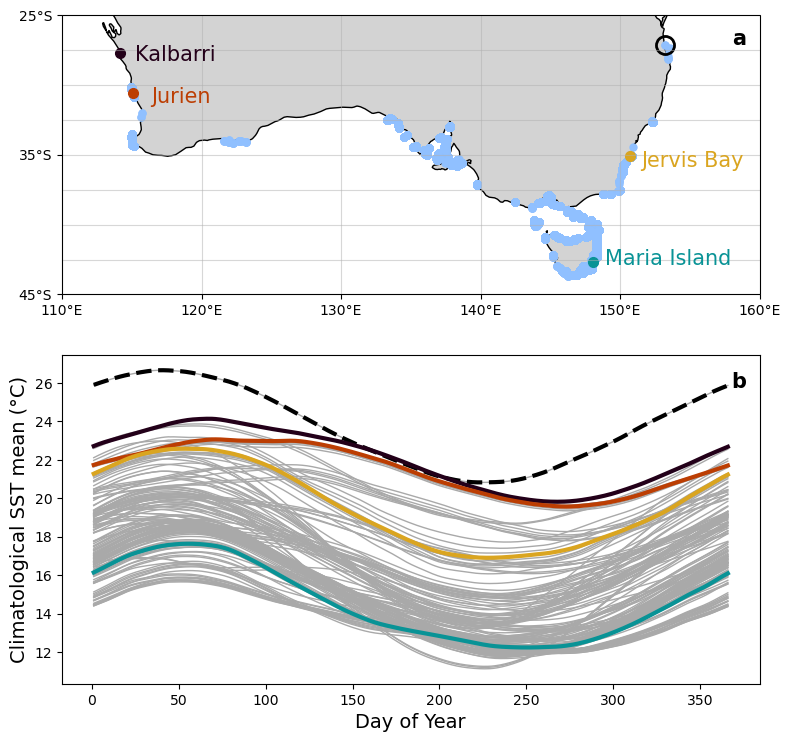

In [13]:
# Create a figure
fig = plt.figure(figsize=(9, 9))

# Add the first subplot with a projection
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.plot(np.array(lon_erobis), np.array(lat_erobis), marker='o', markersize=5, linestyle='none', color=(144/255, 192/255, 255/255), transform=ccrs.PlateCarree())
# ax1.plot(np.array(lon_erobis), np.array(lat_erobis), marker='o', markersize=5, linestyle='none', color='teal', transform=ccrs.PlateCarree())
ax1.plot(115.10, -30.55, marker='o', markersize=7, linestyle='none', color=(188/255, 62/255, 3/255), transform=ccrs.PlateCarree())
ax1.plot(150.75, -35.05, marker='o', markersize=7, linestyle='none', color='goldenrod', transform=ccrs.PlateCarree())
ax1.plot(148.05, -42.65, marker='o', markersize=7, linestyle='none', color=(9/255, 147/255, 150/255), transform=ccrs.PlateCarree())
ax1.plot(114.15, -27.67, marker='o', markersize=7, linestyle='none', color=(35/255, 0/255, 25/255), transform=ccrs.PlateCarree())   ## Kalbarri
ax1.plot(153.21, -27.09, marker='o', markersize=13, markerfacecolor='none', markeredgecolor='black', markeredgewidth=2, color='brown', transform=ccrs.PlateCarree())   ## max temp circle

ax1.coastlines()
ax1.gridlines(alpha=0.5)
# ax1.add_feature(cfeature.OCEAN, facecolor='azure')
ax1.add_feature(cfeature.LAND, facecolor='lightgrey')

ax1.text(118.10, -27.15, 'Kalbarri', fontsize=15, color =(35/255, 0/255, 25/255), verticalalignment='top', horizontalalignment='center', transform=ccrs.Geodetic())
ax1.text(118.50, -30.15, 'Jurien', fontsize=15, color =(188/255, 62/255, 3/255), verticalalignment='top', horizontalalignment='center', transform=ccrs.Geodetic())
ax1.text(155.2, -34.7, 'Jervis Bay', fontsize=15, color ='goldenrod', verticalalignment='top', horizontalalignment='center', transform=ccrs.Geodetic())
ax1.text(153.45, -41.75, 'Maria Island', fontsize=15, color =(9/255, 147/255, 150/255), verticalalignment='top', horizontalalignment='center', transform=ccrs.Geodetic())
# Set the desired x and y range
lon_range = [110, 160]
lat_range = [-45, -25]
# Set the x and y axis limits
ax1.set_xlim(lon_range)
ax1.set_ylim(lat_range)
# Define the tick format functions
lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'S' if x < 0 else 'N'))
lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:}°{}'.format(abs(x), 'W' if x < 0 else 'E'))
# Set the x and y tick positions and labels
ax1.set_xticks(np.arange(lon_range[0], lon_range[1]+1, 10), crs=ccrs.PlateCarree())
ax1.set_xticklabels([lon_formatter(x) for x in ax1.get_xticks()], fontsize=10)
ax1.set_yticks(np.arange(lat_range[0], lat_range[1]+1, 10), crs=ccrs.PlateCarree())
ax1.set_yticklabels([lat_formatter(y) for y in ax1.get_yticks()], fontsize=10)

# Add the second subplot without a projection
ax2 = fig.add_subplot(2, 1, 2)

for i in summarized_df.index:
    lat = summarized_df.Latitude[i]
    lon = summarized_df.Longitude[i]
    # select specific location
    sst_locat = ds.sst.sel(lat = slice(lat-0.25, lat+0.25), lon = slice(lon-0.25, lon+0.25)).mean(dim=["lat", "lon"], skipna=True).squeeze('zlev', drop=True)
    # Skip this iteration if the data is all NaNs
    if sst_locat.isnull().all():
        continue
    clim = threshold(sst_locat) # threshold and climatology
    ax2.plot(np.arange(1, 367), clim.seas.values, linestyle='-', linewidth= 1, color = 'darkgray')
# plot three pop's climatology
sst_limit = ds.sst.sel(lat = slice(max(summarized_df.Latitude)-0.25, max(summarized_df.Latitude)+0.25), lon = slice(153.50-0.25, 153.50+0.25)).mean(dim=["lat", "lon"], skipna=True).squeeze('zlev', drop=True)
clim_limit = threshold(sst_limit) # threshold and climatology
ax2.plot(np.arange(1, 367), clim_limit.seas.values, linestyle='--', linewidth= 3, color = 'k')

sst_kalbarri = ds.sst.sel(lat = slice(-27.67-0.25, -27.67+0.25), lon = slice(114.15-0.25, 114.15+0.25)).mean(dim=["lat", "lon"], skipna=True).squeeze('zlev', drop=True)
clim_kalbarri = threshold(sst_kalbarri) # threshold and climatology
ax2.plot(np.arange(1, 367), clim_kalbarri.seas.values, linestyle='-', linewidth= 3, color = (35/255, 0/255, 25/255))

sst_jurien = ds.sst.sel(lat = slice(-30.55-0.25, -30.55+0.25), lon = slice(115.10-0.25, 115.10+0.25)).mean(dim=["lat", "lon"], skipna=True).squeeze('zlev', drop=True)
clim_jurien = threshold(sst_jurien) # threshold and climatology
ax2.plot(np.arange(1, 367), clim_jurien.seas.values, linestyle='-', linewidth= 3, color = (188/255, 62/255, 3/255))

sst_jervis = ds.sst.sel(lat = slice(-37.05-0.25, -36.05+0.25), lon = slice(150.75-0.25, 150.75+0.25)).mean(dim=["lat", "lon"], skipna=True).squeeze('zlev', drop=True)
clim_jervis = threshold(sst_jervis) # threshold and climatology
ax2.plot(np.arange(1, 367), clim_jervis.seas.values, linestyle='-', linewidth= 3, color = 'goldenrod')

sst_maria = ds.sst.sel(lat = slice(-42.65-0.25, -42.65+0.25), lon = slice(148.05-0.25, 148.05+0.25)).mean(dim=["lat", "lon"], skipna=True).squeeze('zlev', drop=True)
clim_maria = threshold(sst_maria) # threshold and climatology
ax2.plot(np.arange(1, 367), clim_maria.seas.values, linestyle='-', linewidth= 3, color = (9/255, 147/255, 150/255))

ax2.set_ylabel(u'Climatological SST mean (\u00B0C)', fontsize=14)
ax2.set_xlabel('Day of Year', fontsize=14)

ax1.text(0.96, 0.95, 'a', transform=ax1.transAxes, fontsize=15, fontweight='bold', va='top')
ax2.text(0.96, 0.95, 'b', transform=ax2.transAxes, fontsize=15, fontweight='bold', va='top')

plt.subplots_adjust(hspace=0.11) 